## Detection of Anomalies in Financial Transactions using Principal Component Analysis


## Introduction and Experiment Overview

### Fraud and Accounting Information Systems (AIS)

Financial Institutions contain and process sensitive personal information of its customers and they are mandated to ensure the security of the institution, its partners, and the security of the financial sector as a whole. 
However, **fraud**, embezzlement, money laundering, and suspicious terrorist financing pose a major threat to the security of the financial sector. 
**Fraud** is any deceptive action that is purposefully designed to provide the person with an unlawful gain or to deny a right to a victim. Types of fraud include credit card fraud, accounting fraud, wire fraud, securities fraud, and tax fraud. 

A recent study conducted by the auditors of **PwC** in 2020, revealed that 58% of Kenyan respondents experienced economic crimes in the past two years which is higher than the Global average of 47% and that 44% of Kenyan companies that experienced economic crimes had between 6-10 incidents reported in the last 24 months. Out of the economic crimes experienced, Accounting/Financial Statement fraud ranked third in Kenya at 15% with the top internal perpetrators being Operations staff at 53%, Middle management at 28% and Senior management at 18% (PwC, 2020).

**Figure 1:** Hierarchical view of an Accounting Information System (AIS) that records distinct layers of abstraction, namely (1) the business process information, (2) the accounting information as well as the (3) technical journal entry information in designated database tables.

The Accounting Information System shown above indicates 3 distinct levels which are:

1. Business processes
2. Accounting information
3. Journal entries stored in the database.

Such accounting systems collect vast quantities of financial data that also doubles up as electronic evidence. This snapshot containing journal entries information in their designated database tables is just a drop in the ocean of the huge number of entries/transactions recorded per day for a Financial Institution. Relating this to fraud, the financial data steadily collected by such systems may contain valuable traces of suspicious financial transactions. These suspicious transactions are manifested in the form of anomalies in the journal entries.


### Classification of Financial Anomalies

There exists two classes of anomalous journal entries, namely **"global"** and **"local"** anomalies.

> - Global Anomalies, are financial transactions that display highly unusual individual attribute values. These anomalies usually relate to highly skewed attributes e.g. unusual times of posting, or ledgers that are rarely used. It has been standard practice over the years that "red-flag" tests, performed by auditors during annual audits, are specifically designed to capture those types of anomalies. However, such tests might result in a high volume of false positive alerts due to regular reverse postings which are not fraudulent and year-end adjustments usually associated with a low fraud risk.

> - Local Anomalies, are financial transactions that exhibit an unusual or rare combination of attribute values while the individual attribute values occur quite frequently e.g. unusual accounting records.
This type of anomaly is significantly more difficult to detect since perpetrators intend to disguise their activities trying to imitate a regular behavior. As a result, such anomalies usually pose a high fraud risk since they might correspond to e.g. misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow an usual activity pattern.


<img align="middle" style="max-width: 450px; height: auto" src="images/anomalies.png">

In [49]:
#Libraries import
# importing utilities
import os
import sys
from datetime import datetime
import io
import urllib

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing sklearn libraries
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#Random seed initialization
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed

## Financial Fraud Detection Dataset

Below is a descriptive analysis of the labs financial dataset. Furthermore, I shall apply some necessary pre-processing steps to train a PCA model. The dataset is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

First, let us load the dataset and investigate its structure and attributes:

In [4]:
# load the dataset into the notebook kernel
ori_dataset = pd.read_csv('data/fraud_dataset_v2.csv')

In [5]:
# inspect the datasets dimensionalities
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20220726-08:59:35] Transactional dataset of 533009 rows and 10 columns loaded


### Initial Data and Attribute Assessment

Below is the augmented dataset that has been modified to mimick a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [6]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


The attribute `label` in the data is of key importance. I shall use this field throughout the experiment to evaluate the quality of my trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). 

Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

### Anomaly Distribution

In [7]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

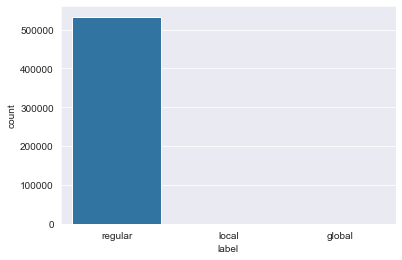

In [12]:
sns.countplot(x=ori_dataset["label"], data=ori_dataset)

This statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies

In [20]:
# remove the "ground-truth" label information for the following steps of the experiment
label = ori_dataset.pop('label')

### Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key `BSCHL` as well as (2) the general ledger account `HKONT`:

Text(0.5, 1.0, 'Distribution of HKONT attribute values')

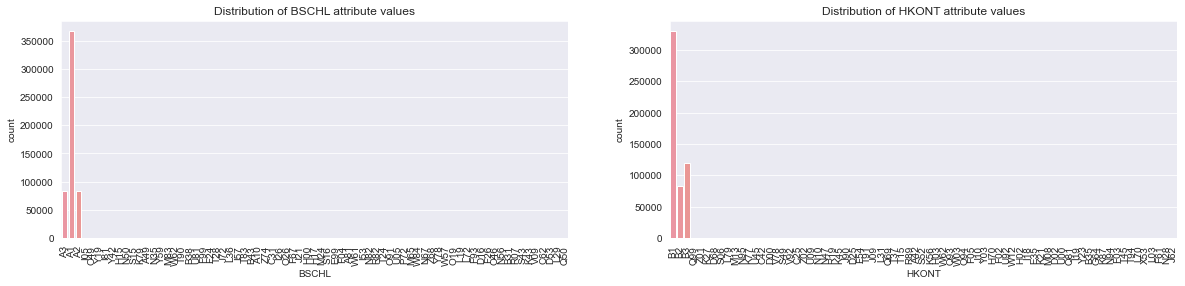

In [21]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

Principal Component Analysis is not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as **"one-hot" encoding**. Using this encoding technique, I shall derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data. This can be achieved using the `get_dummies()` function available in the Pandas data science library:  


In [22]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS', 'BUKRS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

### Encoded transactions

In [23]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W67,BUKRS_W69,BUKRS_W71,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount `DMBTR` and the (2) document currency amount `WRBTR`:

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

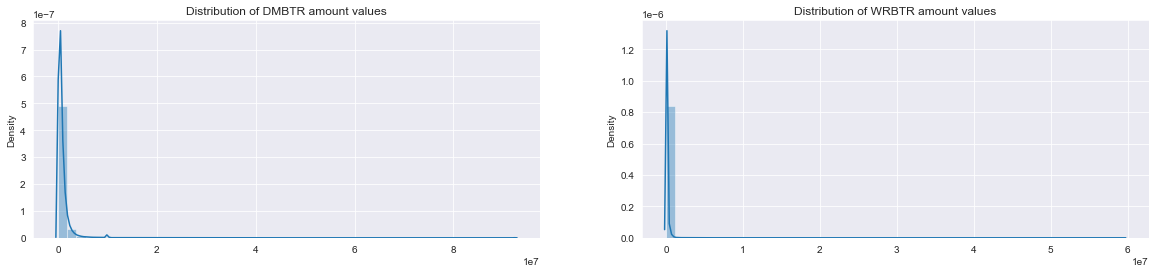

In [24]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

As expected, it can be observed, that for both attributes the distributions of amount values are heavy tailed. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good a practice. Therefore, I first log-scaled both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [25]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

### Visualization of the log-scaled and min-max normalized distributions of both attributes

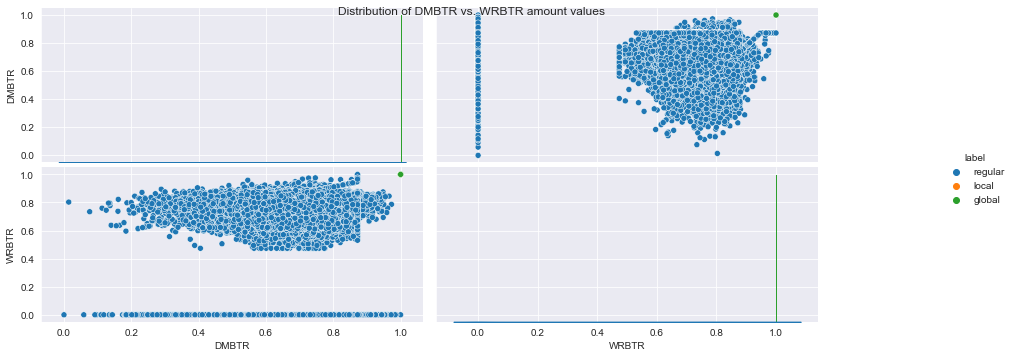

In [26]:
# append 'label' attribute for colour distinction
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

As anticipated the numeric attribute values of the "global" anomalies (green) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (orange) are much more intertwined within the regular transaction amounts.

### Merge Categorical and Numerical Transaction Attributes

Finally, I merged both pre-processed numerical and categorical attributes into a single dataset that we will use for training my PCA model.

In [27]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Let's have a look at the dimensionality of the dataset after I applied the distinct pre-processing steps to the attributes:

In [28]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Ok, upon completion of all the pre-processing steps (incl. the exercises) I ended up with an encoded dataset consisting of a total number of 533,009 records (rows) and **618 encoded attributes** (columns).

# TSNE GRAPHICAL VISUALIZATION OF THE ORIGINAL DATASET

In [29]:
labels = label.replace(['regular','local','global'],[0,1,1])
ori_subset_graph = ori_subset_transformed
ori_subset_graph['label'] = labels
df_fraud = ori_subset_graph[ori_subset_graph['label'] == 1]
ok_sample = ori_subset_graph[ori_subset_graph['label'] == 0].sample(2000)
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne = df_tsne.drop(['label'], axis = 1).values
y_tsne = df_tsne["label"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)





In [30]:
ori_subset_transformed.head()

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98,DMBTR,WRBTR,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.666635,0.000000,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.622241,0.838315,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.737149,0.913897,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.796386,0.775564,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.734257,0.645617,0


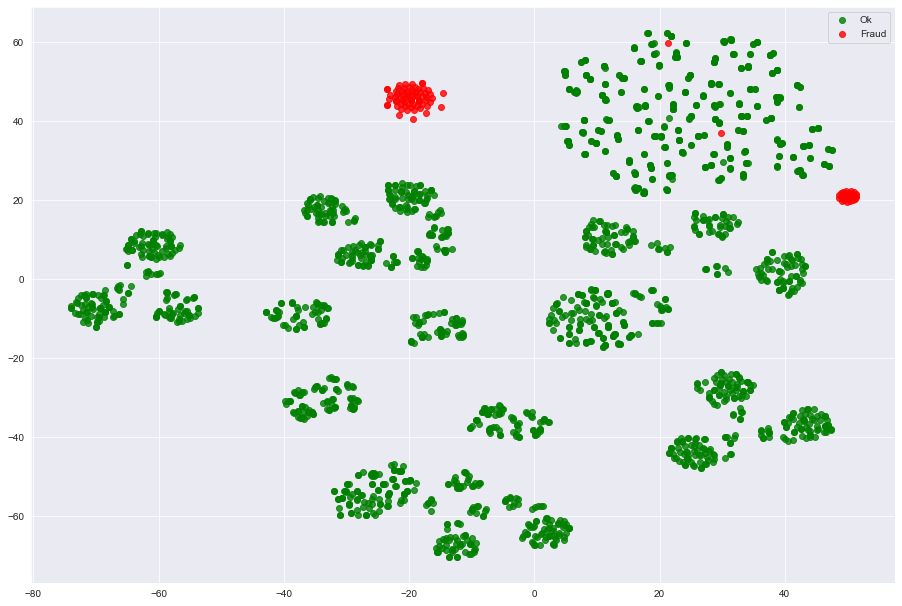

In [31]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth=1, alpha=0.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
ax.legend(loc='best')

The main idea of the PCA approach is to compress the data making a "latent representation" of the original dataset and then reconstructing the data. If a sample is similar to the rest of the dataset, the reconstructed data will be similar or even equal to the original data. However, if the sample is not similar to the rest, the reconstructed sample will not be similar to the original one. Therefore, if the reconstructed data is not similar to the original one, we have a fraud.

# Applying Principal Component Analysis

In our financial fraud dataset, the original feature space has 618 dimensions, known as p dimensions. PCA will project the data onto a smaller subspace of k dimensions (where k < p) while retaining as much of the variation as possible. These k dimensions are known as the principal components.

By applying PCA, we lose some of the variance (i.e., information). By reducing the dimensionality of the data, PCA will reduce the size of the data.

    This will improve the performance of machine learning algorithms.
    This will reduce hardware requirements and speed up the training process.
    This will allow us to easily understand the underlying structure of the data.
    This will allow us to visualize the data on a 2d or 3d plot (if we choose the number of principal components as 2 or 3).

## Using PCA with All Principal Components 

In [32]:
X = ori_subset_transformed
labels = label.replace(['regular','local','global'],[0,1,1])
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
from sklearn.decomposition import PCA
pca_618 = PCA(n_components=618, random_state=2022)
pca_618.fit(X_train)
X_pca_618 = pca_618.transform(X_train)

In [34]:
print('Variance explained by all 618 principal components = ', sum(pca_618.explained_variance_ratio_ * 100))

Variance explained by all 618 principal components =  100.00000000000001


The explained_variance_ratio_ attribute of the PCA() class returns a one-dimensional numpy array which contains the values of the percentage of variance explained by each of the selected components.

In [35]:
pca_618.explained_variance_ratio_ * 100

array([1.39981120e+01, 1.19822407e+01, 5.81826826e+00, 4.71288923e+00,
       4.68292689e+00, 3.31908935e+00, 2.52442546e+00, 2.10467501e+00,
       1.63319840e+00, 1.28539971e+00, 1.27263562e+00, 1.26747051e+00,
       1.26416083e+00, 1.26252258e+00, 1.25772835e+00, 1.25512803e+00,
       1.24918592e+00, 1.16494135e+00, 1.15973234e+00, 1.15844319e+00,
       1.15636134e+00, 1.15462623e+00, 1.15233196e+00, 1.15061945e+00,
       1.14819312e+00, 1.14563255e+00, 1.14506857e+00, 1.14381346e+00,
       1.14185615e+00, 1.13781091e+00, 1.13677085e+00, 1.13367041e+00,
       1.12447528e+00, 1.12188572e+00, 1.10959021e+00, 8.27850695e-01,
       8.13810206e-01, 3.28571723e-01, 3.27558048e-01, 1.25262536e-01,
       1.24828662e-01, 1.23530697e-01, 1.23197343e-01, 1.22727532e-01,
       1.22048018e-01, 1.21621764e-01, 1.21523008e-01, 1.21424450e-01,
       1.21239578e-01, 1.20998744e-01, 1.20741818e-01, 1.20657681e-01,
       1.20511360e-01, 1.20068539e-01, 1.19881255e-01, 1.19577350e-01,
      

The first component alone captures about 44.27% of the variability in the dataset and the second component alone captures about 18.97% of the variability in the dataset and so on. Also, note that the values of the above array are sorted in descending order. Taking the sum of the above array will return the total variance explained by each of the selected components.

In [36]:
# If we get the cumulative sum of the above array, we can see the following array.
np.cumsum(pca_618.explained_variance_ratio_ * 100)

array([ 13.99811199,  25.98035264,  31.79862089,  36.51151012,
        41.19443701,  44.51352636,  47.03795182,  49.14262684,
        50.77582524,  52.06122495,  53.33386057,  54.60133108,
        55.86549191,  57.1280145 ,  58.38574285,  59.64087088,
        60.8900568 ,  62.05499815,  63.21473049,  64.37317368,
        65.52953502,  66.68416125,  67.83649321,  68.98711266,
        70.13530578,  71.28093833,  72.42600689,  73.56982035,
        74.7116765 ,  75.84948741,  76.98625826,  78.11992867,
        79.24440395,  80.36628967,  81.47587988,  82.30373057,
        83.11754078,  83.4461125 ,  83.77367055,  83.89893309,
        84.02376175,  84.14729245,  84.27048979,  84.39321732,
        84.51526534,  84.6368871 ,  84.75841011,  84.87983456,
        85.00107414,  85.12207288,  85.2428147 ,  85.36347238,
        85.48398374,  85.60405228,  85.72393354,  85.84351089,
        85.96307534,  86.08246861,  86.20177542,  86.32079354,
        86.43956731,  86.55820353,  86.67675063,  86.79

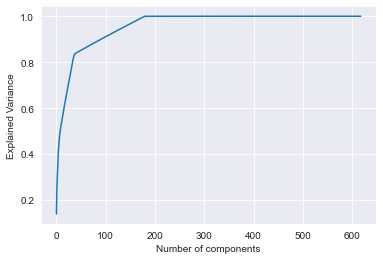

In [37]:
# Then we create the following plot
plt.plot(np.cumsum(pca_618.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.savefig('elbow_plot.png', dpi=100)

In [38]:
#We can deduce the following
print("Variance explained by the First Principal Component = ", 
     np.cumsum(pca_618.explained_variance_ratio_ * 100)[0])
print("Variance explained by the First 50 Principal Components = ", 
     np.cumsum(pca_618.explained_variance_ratio_ * 100)[49])
print("Variance explained by the First 100 Principal Components = ", 
     np.cumsum(pca_618.explained_variance_ratio_ * 100)[99])
print("Variance explained by the First 150 Principal Components = ", 
     np.cumsum(pca_618.explained_variance_ratio_ * 100)[149])
print("Variance explained by the First 180 Principal Components = ", 
     np.cumsum(pca_618.explained_variance_ratio_ * 100)[179])
print("Variance explained by the First 190 Principal Components = ", 
     np.cumsum(pca_618.explained_variance_ratio_ * 100)[189])

Variance explained by the First Principal Component =  13.998111985060662
Variance explained by the First 50 Principal Components =  85.12207288324794
Variance explained by the First 100 Principal Components =  90.99860339080577
Variance explained by the First 150 Principal Components =  96.67907304116939
Variance explained by the First 180 Principal Components =  99.97284427909722
Variance explained by the First 190 Principal Components =  99.98388022109049


You can see that the first 180 principal components keep about 99.97% of the variability in the dataset while reducing 438 (618–180) features in the dataset. That’s great. The remaining 438 features only contain less than 1% of the variability in data.

## Applying PCA using 144 components 

In [39]:
components = 0.96
pca_96 = PCA(n_components=components, random_state=2022)
pca_96.fit(X_train)
X_pca_96 = pca_96.transform(X_train)

In [40]:
X_pca_96.shape

(373106, 144)

This means that the algorithm has found 144 principal components to preserve 96% of the variability in the data. The X_pca_96 array holds the values of all 144 principal components. We can visualize these values as in the following plot.

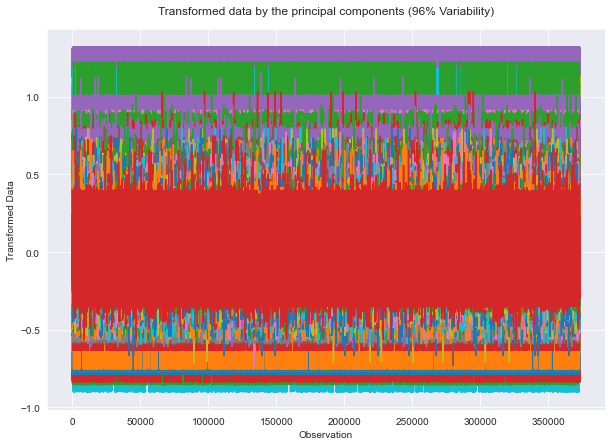

In [41]:
plt.figure(figsize=(10,7))
plt.plot(X_pca_96)
plt.xlabel('Observation')
plt.ylabel('Transformed Data')
plt.title('Transformed data by the principal components (96% Variability)', pad=15)
plt.savefig('plot.png')

In [42]:
# Let’s create a pandas DataFrame using the values of all 144 principal components and add the label column of the original dataset.
#reduced_df = pd.DataFrame(X_pca_96, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','PC26','PC27','PC28','PC29','PC30','PC31','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1','PC1'])
#reduced_df['label']= ori_dataset.label
#reduced_df.head()

In [43]:
#reduced_df.shape

In [44]:
#Save the new reduced df
#reduced_df.to_csv('Fraud_dataset_96.csv', index=False)

# Train Evaluation

In [45]:
X_dt = pca_96.inverse_transform(X_pca_96)
X_dt = pd.DataFrame(X_dt, columns=X_train.columns, index=X_train.index)

reconstruction_score = []
for idx in X_train.index:
    score = mean_squared_error(X_train.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_train.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()

rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > 0.008)].dropna().index
train_fraud_index = list(y_train[y_train == 1].index)

Text(0, 0.5, 'Number of samples')

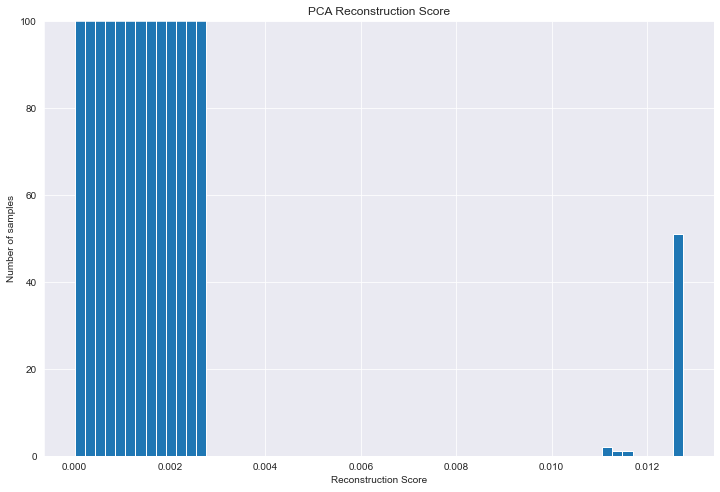

In [46]:
plt.figure(figsize=(12, 8))
rc_scores['reconstruction_score'].hist(bins=60)
plt.ylim(0, 100)
plt.title('PCA Reconstruction Score')
plt.xlabel('Reconstruction Score')
plt.ylabel('Number of samples')

Now, I proceeded to set a threshold to the reconstruction score. Usualy the domain expertise is used to help to set this threshold since it impacts direcly on the precision and recall trade-off. 
Using the mean and standard deviation of the reconstruction score we can set a reasonable threshold. Then, I choose to set the threshold to mean + 2*std. 

Thus, the threshold selected was 0.008

## Classification Report 

In [47]:
pred = pd.DataFrame(index=X_train.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1

print(classification_report(y_train, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_train) * 100, '%')



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    373029
           1       1.00      0.71      0.83        77

    accuracy                           1.00    373106
   macro avg       1.00      0.86      0.92    373106
weighted avg       1.00      1.00      1.00    373106

Rate of transations to investigate: 0.014741119145765546 %


## Report Visualization 

<AxesSubplot:>

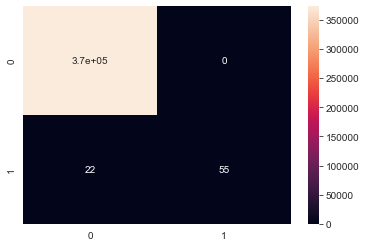

In [51]:
sns.heatmap(confusion_matrix(y_train, pred['fraud']), annot = True)

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, pred['fraud'])

0.999941035523417

> - Accuracy : 99%
> - Precision: 100%
> - Recall : 71%
> - F1 Score: 83%

# Validation Evaluation

In [52]:
X_tt = pca_96.transform(X_test)
X_dt = pca_96.inverse_transform(X_tt)
X_dt = pd.DataFrame(X_dt, columns=X_test.columns, index=X_test.index)

reconstruction_score = []
for idx in X_test.index:
    score = mean_squared_error(X_test.loc[idx], X_dt.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_test.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()

rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > 0.008)].dropna().index
val_fraud_index = list(y_test[y_test == 1].index)



In [53]:
pred = pd.DataFrame(index=X_test.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1
    
print(classification_report(y_test, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_test) * 100, '%')



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159880
           1       1.00      0.65      0.79        23

    accuracy                           1.00    159903
   macro avg       1.00      0.83      0.89    159903
weighted avg       1.00      1.00      1.00    159903

Rate of transations to investigate: 0.00938068704151892 %


## Report Visualization 

<AxesSubplot:>

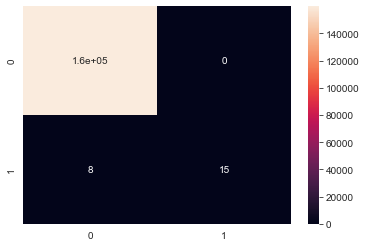

In [54]:
sns.heatmap(confusion_matrix(y_test, pred['fraud']), annot = True)

In [55]:
accuracy_score(y_test, pred['fraud'])

0.9999499696691119

> - Accuracy : 99%
> - Precision: 100%
> - Recall : 65%
> - F1 Score: 79%

# TSNE GRAPHICAL REPRESENTATION OF REDUCED DATASET

In [ ]:
X_pca_tsne = X_pca_96
X_pca_tsne = pd.DataFrame(X_pca_tsne, index=X_train.index)

X_pca_tsne['label'] = y_train
ok_sample = X_pca_tsne[X_pca_tsne['label'] == 0].sample(2000)
df_fraud = X_pca_tsne[X_pca_tsne['label'] == 1]
df_tsne = ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne = df_tsne.values
y_tsne = df_tsne["label"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

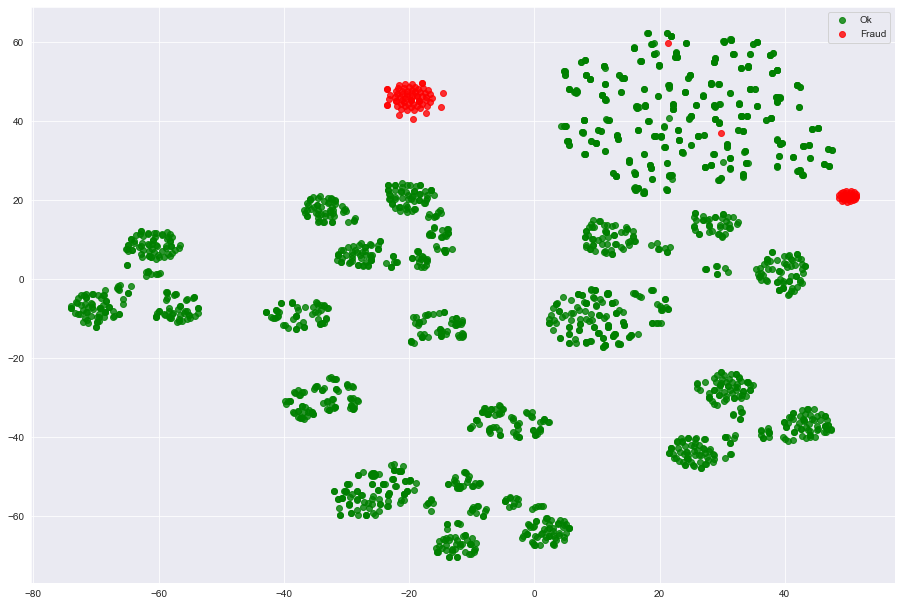

In [57]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth=1, alpha=0.8, label='Ok')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
ax.legend(loc='best')